In [45]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf

import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), "../"))
if project_root not in sys.path:
    sys.path.append(project_root)

CWD = Path().resolve()
PROJECT_ROOT = CWD.parents[1]  # notebooks/ka → heart_and_lungsounds
RAW_ROOT = PROJECT_ROOT / "data" / "raw" / "ka"

AUDIO_DIR = RAW_ROOT / "audio_files"
ANNOT_XLSX = RAW_ROOT / "data_annotation.xlsx"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("RAW_ROOT    :", RAW_ROOT)
print("AUDIO_DIR   :", AUDIO_DIR)
print("ANNOT_XLSX  :", ANNOT_XLSX)

from src.plot_style import set_default_style
from src.plots import histplot, countplot

set_default_style()

PROJECT_ROOT: C:\Users\MSI\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds
RAW_ROOT    : C:\Users\MSI\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\raw\ka
AUDIO_DIR   : C:\Users\MSI\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\raw\ka\audio_files
ANNOT_XLSX  : C:\Users\MSI\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\raw\ka\data_annotation.xlsx


In [46]:
def parse_ka_filename(fname: str) -> dict:
    """
    Example:  BP1_Asthma,I E W,P L L,70,M.wav
    Format:
      1: Filter+Patient → e.g. BP1   (Bell filter, Patient 1)
         - 'B' = filter (Bell)
         - 'P1' = patient ID
      2: Diagnosis
      3: Sound type (I/E/W/C)
      4: Location (e.g. P L L)
      5: Age
      6: Gender
    """
    name = fname.replace(".wav", "")
    parts = name.split(",")

    # First part contains filter+patient and diagnosis
    first = parts[0].split("_")
    filter_patient = first[0]         # e.g. BP1
    diagnosis = first[1] if len(first) > 1 else None

    # Extract filter letter and patient ID number
    filter_type = filter_patient[0]   # B = Bell
    patient_id = filter_patient[1:]   # P1 → 1 (string)

    return {
        "file_name": fname,
        "filter_type": filter_type,
        "patient_id": patient_id,
        "diagnosis": diagnosis,
        "sound_type": parts[1] if len(parts) > 1 else None,
        "location": parts[2] if len(parts) > 2 else None,
        "age": int(parts[3]) if len(parts) > 3 and parts[3].isdigit() else None,
        "gender": parts[4] if len(parts) > 4 else None,
    }

def audio_file_metadata(path: Path) -> dict:
    info = sf.info(str(path))
    return {
        "samplerate": info.samplerate,
        "frames": info.frames,
        "duration_sec": info.frames / info.samplerate,
        "channels": info.channels,
    }

In [47]:
records = []
for wav in sorted(AUDIO_DIR.glob("*.wav")):
    parsed = parse_ka_filename(wav.name)
    meta = audio_file_metadata(wav)
    combined = {**parsed, **meta}
    records.append(combined)

df = pd.DataFrame(records)

print("Audio files:", len(df))
df.head()

Audio files: 336


,file_name,filter_type,patient_id,diagnosis,sound_type,location,age,gender,samplerate,frames,duration_sec,channels
0,"BP100_N,N,P R M,70,F.wav",B,P100,N,N,P R M,70,F,4000,54208,13.552,1
1,"BP101_Asthma,E W,P L M,12,F.wav",B,P101,Asthma,E W,P L M,12,F,4000,54208,13.552,1
2,"BP102_N,N,P L L,41,M.wav",B,P102,N,N,P L L,41,M,4000,76224,19.056,1
3,"BP103_N,N,P R U,81,F.wav",B,P103,N,N,P R U,81,F,4000,51392,12.848,1
4,"BP104_Asthma,E W,P L U,45,F.wav",B,P104,Asthma,E W,P L U,45,F,4000,47040,11.760,1


In [48]:
import pandas as pd

def normalize_ka_diagnosis(diag: str) -> str | None:
    """
    Normaliseer KA diagnosen zodat ze overeenkomen met de gewenste tabel.

    Doelen:
    - Normal      ← N / Normal
    - Asthma      ← asthma / Asthma
    - Heart Failure ← heart failure / Heart Failure /
                      Heart Failure + COPD / Heart Failure + Lung Fibrosis
    - COPD        ← copd / COPD
    - Pneumonia   ← pneumonia
    - BRON        ← Bronchiectasis / Bronchiolitis

    Gedropt:
    - Asthma and lung fibrosis
    - Pleural Effusion (incl. typo Plueral)
    - Lung Fibrosis (komt niet in eindtabel voor)
    """
    if pd.isna(diag):
        return None

    raw = str(diag).strip()
    d = raw.lower()

    # naar "Normal"
    if d in {"n", "normal"}:
        return "Normal"

    # expliciet droppen
    if "asthma and lung fibrosis" in d:
        return None
    if d in {"pleural effusion", "plueral effusion"}:
        return None
    if d == "lung fibrosis":
        return None

    # combinaties naar Heart Failure
    if d in {
        "heart failure + copd",
        "heart failure+copd",
        "heart failure + lung fibrosis",
        "heart failure+lung fibrosis",
    }:
        return "Heart Failure"

    # simpele mappen
    if d == "asthma":
        return "Asthma"
    if d == "copd":
        return "COPD"
    if d == "heart failure":
        return "Heart Failure"
    if d == "pneumonia":
        return "Pneumonia"

    # BRON-groep
    if d in {"bronchiectasis", "bronchiolitis"}:
        return "BRON"

    # fallback: behoud originele string
    return raw


# genormaliseerde diagnose toevoegen
df["diagnosis_norm"] = df["diagnosis"].apply(normalize_ka_diagnosis)

# alleen rijen met geldige diagnose
full_diag = df.dropna(subset=["diagnosis_norm"]).copy()

# één rij per patiënt, diagnose, geslacht
patient_sex_diag = (
    full_diag[["patient_id", "diagnosis_norm", "gender"]]
    .drop_duplicates()
)

# aantal subjects per diagnose en geslacht
subj_counts = (
    patient_sex_diag.groupby(["diagnosis_norm", "gender"])["patient_id"]
    .nunique()
    .unstack(fill_value=0)
)

# aantal recordings per diagnose
rec_counts = (
    full_diag.groupby("diagnosis_norm")["file_name"]
    .nunique()
)


def format_subjects(row: pd.Series) -> str:
    f = int(row.get("F", 0))
    m = int(row.get("M", 0))
    total = f + m
    return f"{total} ({f}F, {m}M)"


# eindtabel
table_ka = pd.DataFrame(index=subj_counts.index)
table_ka["# subjects"] = subj_counts.apply(format_subjects, axis=1)
table_ka["# recordings"] = rec_counts

table_ka = (
    table_ka.reset_index()
    .rename(columns={"diagnosis_norm": "Diagnosis"})
    .sort_values("Diagnosis")
    .reset_index(drop=True)
)

print(table_ka)

       Diagnosis     # subjects  # recordings
0         Asthma  32 (17F, 15M)            96
1           BRON     3 (1F, 2M)             9
2           COPD     9 (1F, 8M)            27
3  Heart Failure   21 (9F, 12M)            63
4         Normal  35 (11F, 24M)           105
5      Pneumonia     5 (2F, 3M)            15


In [49]:
# Load only the columns we actually want: Age → Diagnosis
annot_df = pd.read_excel(
    ANNOT_XLSX,
    usecols="A:D"   # Age, Gender, Location, Sound type, Diagnosis (adjust if necessary)
)

print("Annotation rows:", len(annot_df))

# Add patient column starting from 100
annot_df.insert(0, "Patient ID", range(100, 100 + len(annot_df)))

annot_df.head()

Annotation rows: 154


,Patient ID,Age,Gender,Location,Sound type
0,100,70.0,M,P L L,I E W
1,101,52.0,F,P L L,E W
2,102,50.0,F,P L L,I E W
3,103,72.0,F,P R L,I C
4,104,71.0,M,P R L,I C E W


In [50]:
print("\nSamplerates:", df["samplerate"].value_counts())
print("\nGenders:", df["gender"].value_counts(dropna=False))


Samplerates: samplerate
4000    336
Name: count, dtype: int64

Genders: gender
M    207
F    129
Name: count, dtype: int64


In [51]:
print("\nDiagnosis (from filenames):")
print(df["diagnosis"].value_counts())


Diagnosis (from filenames):
diagnosis
N                                 105
Asthma                             51
heart failure                      45
asthma                             45
COPD                               24
pneumonia                          15
Lung Fibrosis                      12
Heart Failure                       9
BRON                                9
Heart Failure + COPD                6
Plueral Effusion                    6
Asthma and lung fibrosis            3
copd                                3
Heart Failure + Lung Fibrosis       3
Name: count, dtype: int64


In [52]:
df.head(3)

,file_name,filter_type,patient_id,diagnosis,sound_type,location,age,gender,samplerate,frames,duration_sec,channels,diagnosis_norm
0,"BP100_N,N,P R M,70,F.wav",B,P100,N,N,P R M,70,F,4000,54208,13.552,1,Normal
1,"BP101_Asthma,E W,P L M,12,F.wav",B,P101,Asthma,E W,P L M,12,F,4000,54208,13.552,1,Asthma
2,"BP102_N,N,P L L,41,M.wav",B,P102,N,N,P L L,41,M,4000,76224,19.056,1,Normal


In [53]:
print(df["samplerate"].value_counts())

samplerate
4000    336
Name: count, dtype: int64


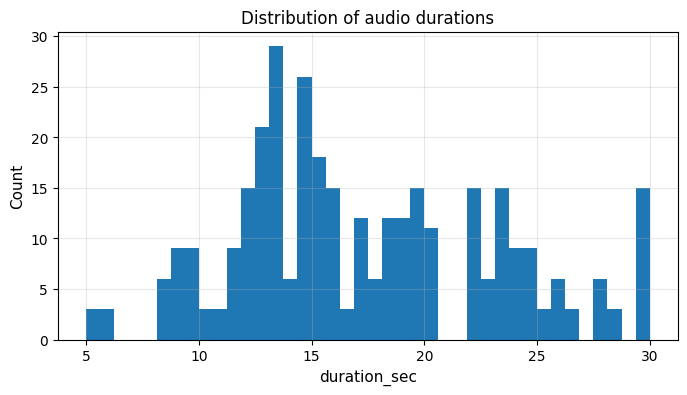

count    336.000000
mean      17.399119
std        5.777563
min        5.000000
25%       13.216000
50%       15.984000
75%       22.064000
max       30.000000
Name: duration_sec, dtype: float64

In [54]:
fig, ax = plt.subplots(figsize=(8, 4))
histplot(df, "duration_sec", bins=40, ax=ax, title="Distribution of audio durations")
plt.show()

df["duration_sec"].describe()

C:\Users\MSI\AppData\Local\Temp\ipykernel_46132\894557005.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


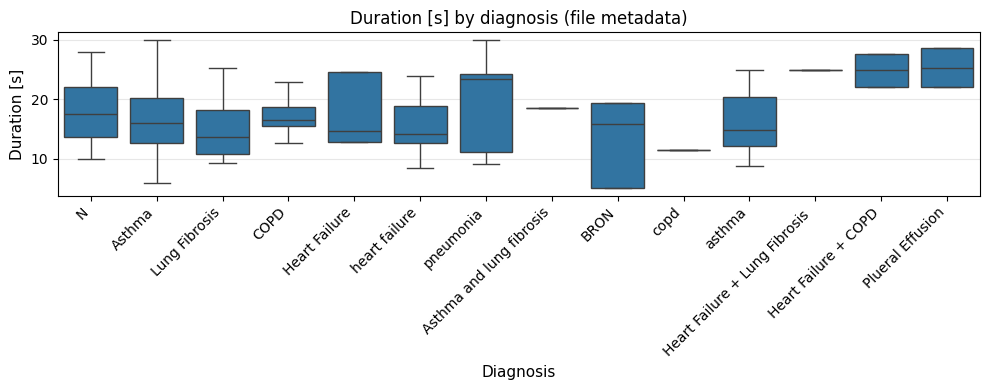

In [55]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(data=df, x="diagnosis", y="duration_sec", ax=ax, showfliers=False)
ax.set_title("Duration [s] by diagnosis (file metadata)")
ax.set_xlabel("Diagnosis")
ax.set_ylabel("Duration [s]")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

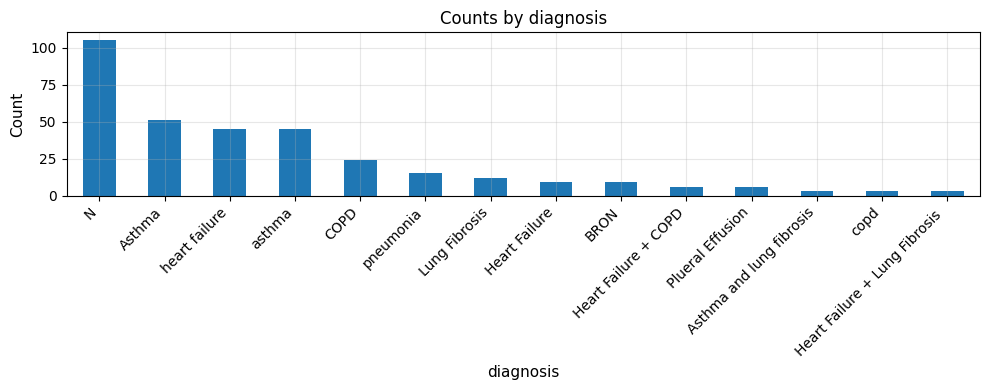

In [56]:
fig, ax = plt.subplots(figsize=(10, 4))
countplot(df, "diagnosis", ax=ax, title="Counts by diagnosis")
plt.tight_layout()
plt.show()


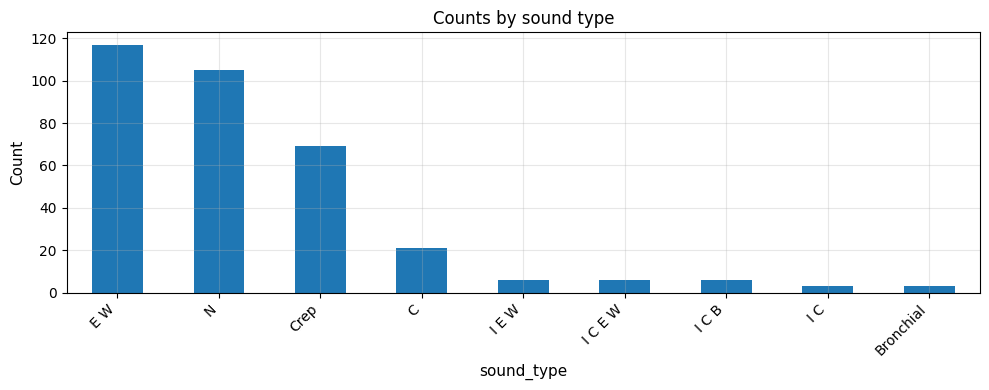

In [57]:
fig, ax = plt.subplots(figsize=(10, 4))
countplot(df, "sound_type", ax=ax, title="Counts by sound type")
plt.tight_layout()
plt.show()


In [58]:
def run_sanity_asserts(df):
    # No zero duration
    assert (df["duration_sec"] <= 0).sum() == 0, "Found zero-duration files!"

    # Reasonable samplerates
    assert df["samplerate"].nunique() <= 5, "Unexpected variety in samplerates"

    # Basic columns exist
    required = ["diagnosis", "sound_type", "location", "age", "gender"]
    for col in required:
        assert col in df.columns, f"Missing column {col}"

    print("All sanity checks passed")

run_sanity_asserts(df)

All sanity checks passed


In [59]:
# export to CSV
# export annotations_df to processed folder
output_csv_path = PROJECT_ROOT / "data" / "processed" / "ka" / "ka_meta_annotation_data.csv"
output_csv_path.parent.mkdir(parents=True, exist_ok=True)  # create dirs if not

df.to_csv(output_csv_path, index=False)